In [1]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Dict, Optional

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from models import LlamaForCausalLM, GPT2CompressConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate.utils import set_seed

/usr/scratch/haokang/anaconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"
ANSWER_PROMPT = "The final answer is: "
QUESTION_PROMPT = "\nAnswer the above question. First think step by step and then answer the final number.\n"

In [3]:
MODEL_ID = "LoftQ/Llama-2-7b-hf-fp16-64rank-gsm8k"
UNTUNE_ID = "meta-llama/Llama-2-7b-hf"

In [4]:
model = LlamaForCausalLM.from_pretrained(
        UNTUNE_ID,
        torch_dtype=torch.bfloat16,  # you may change it with different models
        token=None,
        device_map="auto",
        cache_dir="../cache",
        use_cache=False,
    )
TOKEN_ID = "meta-llama/Llama-2-7b-hf"
tokenizer = transformers.AutoTokenizer.from_pretrained(
    TOKEN_ID,
    # model_args.model_name_or_path,
    token=None,
    model_max_length=512,
    padding_side="left",
    use_fast=False,
    cache_dir="../cache",
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


In [5]:
def smart_tokenizer_and_embedding_resize(
    special_tokens_dict: Dict,
    tokenizer: transformers.PreTrainedTokenizer,
    model: transformers.PreTrainedModel,
):
    """Resize tokenizer and embedding.

    Note: This is the unoptimized version that may make your embedding size not be divisible by 64.
    """
    num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

    if num_new_tokens > 0:
        input_embeddings = model.get_input_embeddings().weight.data
        output_embeddings = model.get_output_embeddings().weight.data

        input_embeddings_avg = input_embeddings[:-num_new_tokens].mean(
            dim=0, keepdim=True
        )
        output_embeddings_avg = output_embeddings[:-num_new_tokens].mean(
            dim=0, keepdim=True
        )

        input_embeddings[-num_new_tokens:] = input_embeddings_avg
        output_embeddings[-num_new_tokens:] = output_embeddings_avg
special_tokens_dict = dict()
if tokenizer.pad_token is None:
    special_tokens_dict["pad_token"] = DEFAULT_PAD_TOKEN
if tokenizer.eos_token is None:
    special_tokens_dict["eos_token"] = DEFAULT_EOS_TOKEN
if tokenizer.bos_token is None:
    special_tokens_dict["bos_token"] = DEFAULT_BOS_TOKEN
if tokenizer.unk_token is None:
    special_tokens_dict["unk_token"] = DEFAULT_UNK_TOKEN

smart_tokenizer_and_embedding_resize(
    special_tokens_dict=special_tokens_dict,
    tokenizer=tokenizer,
    model=model,
)

In [6]:
dataset = load_dataset("gsm8k", "main", cache_dir="./cache")
test_set = dataset["test"]

In [7]:
question = [f"{example['question']}{QUESTION_PROMPT}" for example in test_set]
answer = []

# get numerical answer
for example in test_set["answer"]:
    ans = example.split("####")[-1]
    ans = ans.replace(",", "")  # handle numbers like 2,000
    try:
        ans = float(ans)
    except ValueError:
        ans = float("inf")
    answer.append(ans)

logging.warning("Tokenizing inputs...")
eval_step = math.ceil(len(question) / 1)
logging.warning(
    f"Total example: {len(question)} | eval batch size: {1}"
    f"eval steps: {eval_step}"
)
question_data = []
for i in range(eval_step):
    if i < eval_step - 1:
        batch = tokenizer(
            question[i * 1 : (i + 1) * 1],
            return_tensors="pt",
            padding="longest",
        )
    else:
        batch = tokenizer(
            question[i * 1 :],
            return_tensors="pt",
            padding="longest",
        )
    batch["input_len"] = len(batch["input_ids"][0])
    question_data.append(batch)

model.eval()
gen_kwargs = {
    "max_new_tokens": 512,
    "temperature": 0.8,
    "top_k": 40,
    "top_p": 0.95,
    "do_sample": True,
    "use_cache": False,
}
ans_pred_list = []
set_seed(42)
import time

In [8]:
for step, batch in enumerate(question_data):
    with torch.no_grad():
        gen_kwargs["input_ids"] = batch["input_ids"].to("cuda")
        gen_kwargs["attention_mask"] = batch["attention_mask"].to("cuda")
        start = time.time()
        generated_tokens = model.generate(**gen_kwargs)
        torch.cuda.synchronize()
        end = time.time()
        print(generated_tokens.shape,gen_kwargs["input_ids"].shape)
        print(end - start)
        break
    pred_tokens = generated_tokens[:, batch["input_len"] :]
    decoded_pred = tokenizer.batch_decode(pred_tokens, skip_special_tokens=True)

    # Extract the numbers in sentences
    print(decoded_pred)



torch.Size([1, 321]) torch.Size([1, 93])
122.11967515945435


torch.Size([1, 32, 189, 189])


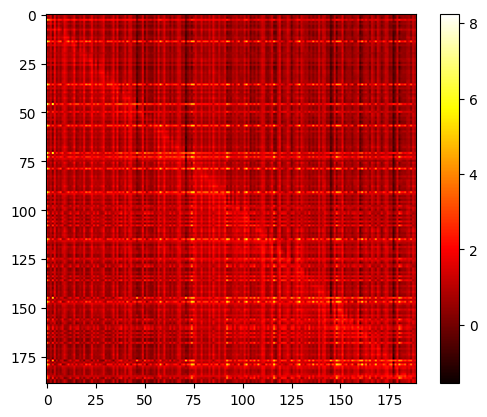

tensor(8.2500) tensor(-1.5469)


In [9]:
laod_tensor = torch.load('attn_weights_save0.pt')
print(laod_tensor.shape)
_,_,l,l = laod_tensor.shape
visualize_attn = laod_tensor[:,10,:,:].view(l,l).float()
import matplotlib.pyplot as plt

# Assuming `tensor` is your PyTorch tensor

# Convert the tensor to a numpy array
array = visualize_attn.numpy()

# Plotting the heatmap
plt.imshow(array, cmap='hot')
plt.colorbar()
plt.show()
# print(visualize_attn)
print(visualize_attn.max(),visualize_attn.min())

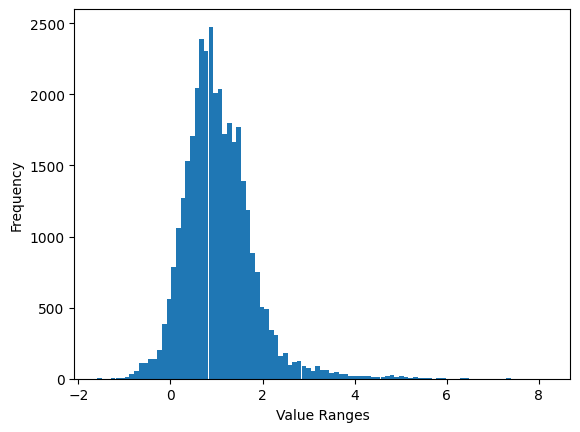

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming `tensor` is your PyTorch tensor

# Flatten the tensor to a 1D array
array = visualize_attn.flatten().numpy()

# Define the range and bin size
start = visualize_attn.min().item()
end = visualize_attn.max().item()
bin_size = 0.1

# Calculate the number of values in each range
bins = int((end - start) / bin_size)
hist, bins = np.histogram(array, bins=bins, range=(start, end))

# Plot the histogram
plt.bar(bins[:-1], hist, width=bin_size)
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')
plt.show()

torch.Size([1, 32, 320, 320])


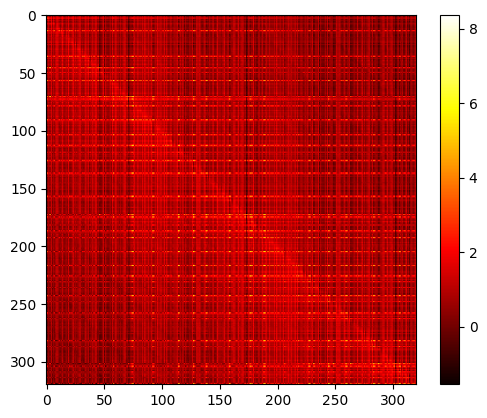

tensor(8.3750) tensor(-1.5469)


In [11]:
laod_tensor = torch.load('attn_weights_save_untune0.pt')
print(laod_tensor.shape)
_,_,l,l = laod_tensor.shape
visualize_attn = laod_tensor[:,10,:,:].view(l,l).float()
import matplotlib.pyplot as plt

# Assuming `tensor` is your PyTorch tensor

# Convert the tensor to a numpy array
array = visualize_attn.numpy()

# Plotting the heatmap
plt.imshow(array, cmap='hot')
plt.colorbar()
plt.show()
# print(visualize_attn)
print(visualize_attn.max(),visualize_attn.min())

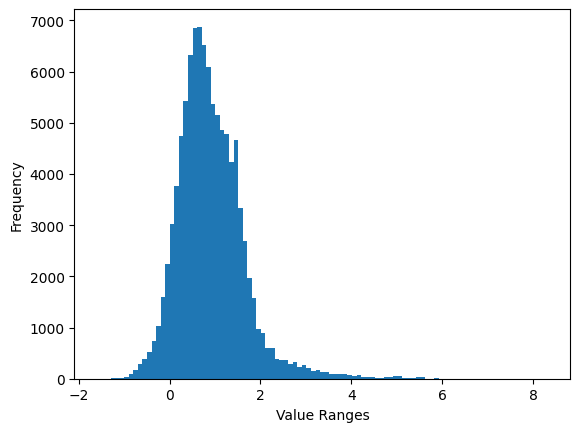

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming `tensor` is your PyTorch tensor

# Flatten the tensor to a 1D array
array = visualize_attn.flatten().numpy()

# Define the range and bin size
start = visualize_attn.min().item()
end = visualize_attn.max().item()
bin_size = 0.1

# Calculate the number of values in each range
bins = int((end - start) / bin_size)
hist, bins = np.histogram(array, bins=bins, range=(start, end))

# Plot the histogram
plt.bar(bins[:-1], hist, width=bin_size)
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')
plt.show()